<a href="https://colab.research.google.com/github/takao8/MLTSA_JClifford/blob/master/HW6/HW6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NOTE: HW6 starts halway down this script.  HW5 was included at the beginning so I can compute the allfeatures matrix.

# Task 1: setup and Data Retrieval

This step is straightforward: I downloaded the dataset from kaggle, unzipped, and got them into colab with pandas.read_csv

In [1]:
import json
import os
import pandas as pd
import numpy as np
import pylab as pl

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# mounting the google drive
from google.colab import drive

drive.mount("/content/gdrive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
# getting into the correst spot for the kaggle.json
cd gdrive/My\ Drive/

/content/gdrive/My Drive


In [0]:
!chmod 600 kaggle.json

In [0]:
envs = json.load(open("kaggle.json", "r"))       # opens our kaggle.json file
os.environ["KAGGLE_USERNAME"] = envs['username']   #gets our username from the json file
os.environ["KAGGLE_KEY"] = envs['key']     #gets our key

In [7]:
cd MLSTA1/

/content/gdrive/My Drive/MLSTA1


In [0]:
!mkdir HW5/

mkdir: cannot create directory ‘HW5/’: File exists


In [8]:
cd HW5/

/content/gdrive/My Drive/MLSTA1/HW5


In [9]:
cd data

/content/gdrive/My Drive/MLSTA1/HW5/data


In [0]:
# now that we're in the directory we want, we'll download and unzip
!kaggle competitions download -c PLAsTiCC-2018

test_set_metadata.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test_set_batch7.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test_set_batch6.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
training_set.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test_set_sample.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
training_set_metadata.csv: Skipping, found more recently modified local copy (use --force to force download)
test_set_batch4.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test_set_batch3.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test_set_batch1.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
data_note.pdf.zip: Skipping, found m

In [0]:
!ls

data_note.pdf.zip	   test_set_batch4.csv.zip  test_set_metadata.csv.zip
sample_submission.csv.zip  test_set_batch5.csv.zip  test_set_sample.csv.zip
test_set_batch10.csv.zip   test_set_batch6.csv.zip  training_set.csv
test_set_batch11.csv.zip   test_set_batch7.csv.zip  training_set.csv.zip
test_set_batch1.csv.zip    test_set_batch8.csv.zip  training_set_metadata.csv
test_set_batch2.csv.zip    test_set_batch9.csv.zip
test_set_batch3.csv.zip    test_set.csv.zip


In [0]:
!unzip training_set.csv.zip

Archive:  training_set.csv.zip
replace training_set.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# Task 2: Minor Data Preparation

Now that the data is downlaoded, I'll read in the 2 csv files we need and do minor prep for the notebook ahead.

In [0]:
lcvs = pd.read_csv("training_set.csv")

In [11]:
print("The dataset contains: (observations, columns)", lcvs.shape)

The dataset contains: (observations, columns) (1421705, 6)


In [12]:
lcvs.head()

,object_id,mjd,passband,flux,flux_err,detected
0,615,59750.4229,2,-544.810303,3.622952,1
1,615,59750.4306,1,-816.434326,5.553370,1
2,615,59750.4383,3,-471.385529,3.801213,1
3,615,59750.4450,4,-388.984985,11.395031,1
4,615,59752.4070,2,-681.858887,4.041204,1


In [13]:
bands = lcvs["passband"].unique()
print("Passbands (filter) identifiers:", bands)

Passbands (filter) identifiers: [2 1 3 4 5 0]


In [14]:
objects = lcvs["object_id"].unique()
print("There are {} astrophysical simulated objects in my dataset".format(objects.shape[0]))

There are 7848 astrophysical simulated objects in my dataset


In [15]:
metadata = pd.read_csv("training_set_metadata.csv")
metadata.head()

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
0,615,349.046051,-61.943836,320.796530,-51.753706,1,0.0000,0.0000,0.0000,NaN,0.017,92
1,713,53.085938,-27.784405,223.525509,-54.460748,1,1.8181,1.6267,0.2552,45.4063,0.007,88
2,730,33.574219,-6.579593,170.455585,-61.548219,1,0.2320,0.2262,0.0157,40.2561,0.021,42
3,745,0.189873,-45.586655,328.254458,-68.969298,1,0.3037,0.2813,1.1523,40.7951,0.007,90
4,1124,352.711273,-63.823658,316.922299,-51.059403,1,0.1934,0.2415,0.0176,40.4166,0.024,90


In [16]:
metadata.columns

Index(['object_id', 'ra', 'decl', 'gal_l', 'gal_b', 'ddf', 'hostgal_specz',
       'hostgal_photoz', 'hostgal_photoz_err', 'distmod', 'mwebv', 'target'],
      dtype='object')

In [17]:
print("The metadata dataset contains more information for each time series: (time-series, columns)", metadata.shape)

The metadata dataset contains more information for each time series: (time-series, columns) (7848, 12)


# Task 3: Data Visualization

In [0]:
norm_band = Normalize(vmin=bands.min(), vmax=bands.max())

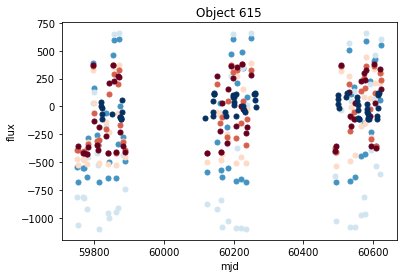

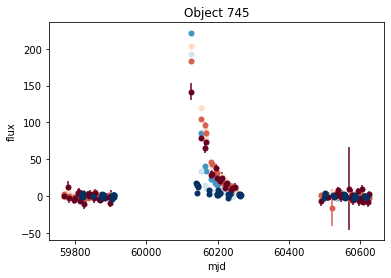

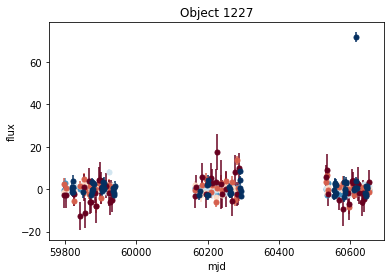

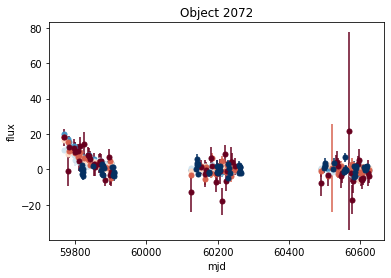

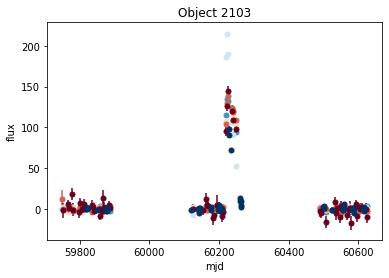

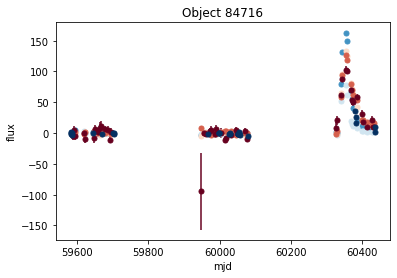

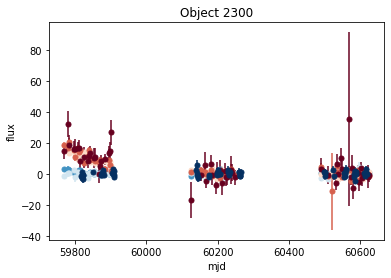

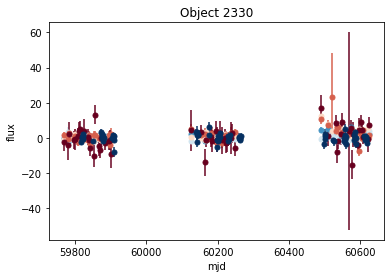

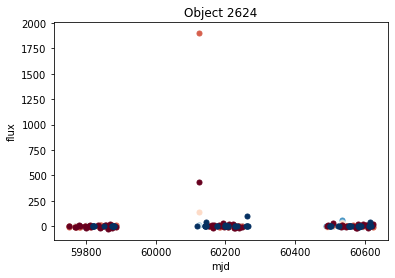

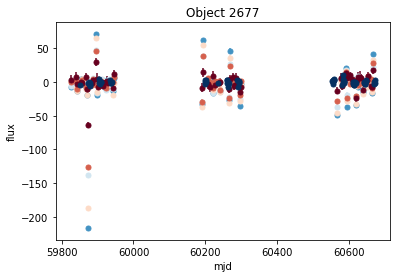

In [19]:
a = lcvs.loc[lcvs["object_id"]==objects[0]]
a.head()
for o in [objects[0], objects[3], objects[5], objects[10], objects[11], 84716, 
          objects[12], objects[13], objects[14], objects[15]]:
  for d in bands:
    a = lcvs.loc[(lcvs["object_id"]==o) & (lcvs["passband"]==d)]
    pl.errorbar(a["mjd"], a["flux"], yerr=a["flux_err"], 
      color=[pl.cm.RdBu_r(Normalize(vmin=bands.min(), vmax=bands.max())(c)) for c in bands][d-1], 
      fmt='.', ms=10, mew=1)
    pl.title("Object %s" % o)
    pl.ylabel("flux")
    pl.xlabel("mjd")
  pl.show()

Figure 1: Time series plots of multiple objects and their flux and errors.  Note that the x-axis is time, represented by the label mjd.  Note also the colorcode indicates which band each datapoint is in: points that are more red are in lower bands, while points that are more blue are in higher bands.  Significant clustering appears in all plots, one such example in Object 2103, showing the 3 clusters along flux=0 along with a cluster directed upwards at around mjd=60250.

# Task 4: Extract Features

# 4.1

After finishing this homework, I realize I wish I had more time to work on this and the t-SNE, but for this week I don't, so I only added the minimum 6 variables needed.  They are:

Original lightcurve: 3rd (skewness) and 4th (kurtosis) moments.  Like mean and variance, moments are always useful to have for a dataset.  They are continuous and are unbounded.

Standardized lightcurve: median, straight line fit.  Median is a good indicatior of the middle of the dataset when significant outliers exist, and will exist as a positive and (potentially) unbounded variable.  The line fit statistics are always useful--the slope and intercept can also technically be unbounded, but they will come as two separate variables.


Metadata: decl, ddf.  decl indicates the position in the sky, and is potentially unbounded. ddf is a binary variable, indicating the type of survey used for the data.

# 4.2 - Extracting from the Original Lightcurve

Here we'll extract the 3rd and 4th moments from the standard lightcurve.  I realize that getting the other statistics are straightforward, but for the interest of time I only got those 2.

In [0]:
from scipy import stats 
def m3(x):   # skewness
    return stats.moment(x, moment = 3)
def m4(x):   # kurtosis
    return stats.moment(x, moment = 4)
mom3 = lcvs.groupby(["object_id", "passband"]).flux.apply(m3)
mom4 = lcvs.groupby(["object_id", "passband"]).flux.apply(m4)

In [21]:
#pd.DataFrame(mom4).rename({"flux": "m3"}, axis=1)
features = pd.concat([mom3, mom4], axis=1)
features.columns=["m3", "m4"]
features.head()

m3            m4
object_id passband                            
615       0         7.266579e+04  7.433032e+07
          1         8.593916e+07  2.215166e+11
          2         3.040627e+07  6.659406e+10
          3         1.049664e+07  1.919999e+10
          4         4.717542e+06  1.036570e+10

# 4.3 - Standardizing Lightcurve and Extracting Features

In this step, we standardize the dataset using groupby and apply, then add our median and linfit statistics.

In [0]:
lcvs["fluxnormed"] = 0.

In [0]:
def normed(df):
   df["fluxnormed"] = (df.flux - df.mean().flux)/df.std().flux
   return df
lcvsnorm = lcvs.groupby(["object_id", "passband"]).apply(normed)

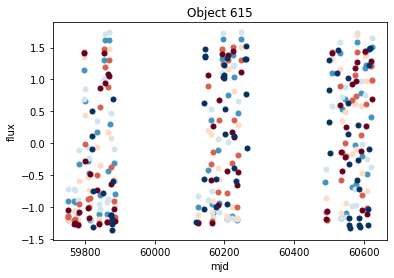

In [24]:
for d in bands:
    a = lcvsnorm.loc[(lcvsnorm["object_id"]==615) & (lcvsnorm["passband"]==d)]
    pl.errorbar(a["mjd"], a["fluxnormed"], 
      color=[pl.cm.RdBu_r(Normalize(vmin=bands.min(), vmax=bands.max())(c)) for c in bands][d-1], 
      fmt='.', ms=10, mew=1)
    pl.title("Object 615")
    pl.ylabel("flux")
    pl.xlabel("mjd")
pl.show()

Figure 2: Verification normalization worked.  Comparison to the same object in Figure 1 confirms the same shape with different magnitude.  I couldn't figure out why the colors didn't match, but the shapes do match and for purposes of the notebook is all that matters.

In [0]:
medians = lcvsnorm.groupby(["object_id", "passband"])[["fluxnormed"]].median()
features["medians"] = medians

In [0]:
def linfit(x):
    pars = np.polyfit(range(len(x)), x["fluxnormed"].values, 1)
    return pars
linfits = lcvsnorm.groupby(["object_id", "passband"]).apply(linfit)

In [0]:
slopes = [x[0] for x in linfits.values[:]]
intercepts = [x[1] for x in linfits.values[:]]
features["slopes"] = slopes
features["intercepts"] = intercepts

In [28]:
features.head()

m3            m4   medians    slopes  intercepts
object_id passband                                                            
615       0         7.266579e+04  7.433032e+07 -0.080537  0.005676   -0.175947
          1         8.593916e+07  2.215166e+11 -0.170090  0.014032   -0.399902
          2         3.040627e+07  6.659406e+10 -0.289021  0.017676   -0.503760
          3         1.049664e+07  1.919999e+10 -0.122434  0.020475   -0.583524
          4         4.717542e+06  1.036570e+10 -0.163078  0.022343   -0.636786

Thus we verify that our statistics are added correctly.

# Task 5 - Unstacking the features and adding Metadata

Note as said before that we're adding decl and ddf from the metadata file.  We make final adjustments to our features dataset and add these variables before moving on.

In [0]:
allfeatures = features.reset_index().set_index(['object_id','passband']).stack(
    ).unstack([1,2])

In [30]:
allfeatures = allfeatures.merge(metadata[["decl", "object_id"]], left_on="object_id", right_on="object_id")
allfeatures = allfeatures.merge(metadata[["ddf", "object_id"]], left_on="object_id", right_on="object_id")
allfeatures = allfeatures.merge(metadata[["target", "object_id"]], left_on="object_id", right_on="object_id")

/usr/local/lib/python3.6/dist-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


In [31]:
allfeatures.head()

,object_id,"(0, m3)","(0, m4)","(0, medians)","(0, slopes)","(0, intercepts)","(1, m3)","(1, m4)","(1, medians)","(1, slopes)","(1, intercepts)","(2, m3)","(2, m4)","(2, medians)","(2, slopes)","(2, intercepts)","(3, m3)","(3, m4)","(3, medians)","(3, slopes)","(3, intercepts)","(4, m3)","(4, m4)","(4, medians)","(4, slopes)","(4, intercepts)","(5, m3)","(5, m4)","(5, medians)","(5, slopes)","(5, intercepts)",decl,ddf,target
0,615,72665.792850,7.433032e+07,-0.080537,0.005676,-0.175947,8.593916e+07,2.215166e+11,-0.170090,0.014032,-0.399902,3.040627e+07,6.659406e+10,-0.289021,0.017676,-0.503760,1.049664e+07,1.919999e+10,-0.122434,0.020475,-0.583524,4.717542e+06,1.036570e+10,-0.163078,0.022343,-0.636786,3.041829e+06,1.049535e+10,-0.129163,0.021319,-0.596932,-61.943836,1,92
1,713,89.634243,4.907398e+03,-0.052914,-0.041433,1.429423,-1.551087e+01,1.944373e+03,0.080189,-0.051648,1.420320,-4.127475e+00,1.935955e+03,0.117188,-0.053887,1.481892,-4.249286e+01,3.091660e+03,0.141552,-0.050983,1.402038,-1.597455e+01,2.938985e+03,0.016870,-0.050464,1.387765,7.377121e+01,5.294322e+03,-0.094281,-0.037903,1.042343,-27.784405,1,88
2,730,2.093148,3.655013e+01,0.039463,-0.001798,0.063840,2.623669e+00,3.870188e+01,0.016754,0.003167,-0.080770,3.864890e+02,6.926529e+03,-0.343392,0.026905,-0.686084,1.380135e+03,4.048490e+04,-0.314425,0.024491,-0.624531,2.936931e+03,1.060595e+05,-0.308522,0.022552,-0.563811,3.751336e+03,1.860606e+05,-0.149763,0.019612,-0.490299,-6.579593,1,42
3,745,162.368381,2.575248e+03,-0.169349,-0.013089,0.464675,1.161627e+05,2.162844e+07,-0.185994,-0.003826,0.105205,1.758302e+05,3.606109e+07,-0.290606,-0.003878,0.106641,1.519142e+05,2.575691e+07,-0.373246,-0.003931,0.108112,1.190633e+05,1.781661e+07,-0.358773,-0.004774,0.131296,5.309464e+04,6.203072e+06,-0.306851,-0.002816,0.076043,-45.586655,1,90
4,1124,-4.160853,1.101222e+02,-0.033864,0.017117,-0.530614,1.202103e+03,3.545471e+04,-0.429236,0.028666,-0.816982,2.827915e+04,2.468546e+06,-0.438785,0.025384,-0.723449,6.198814e+04,7.271993e+06,-0.383411,0.021342,-0.608237,7.183273e+04,9.005039e+06,-0.303771,0.019736,-0.562470,3.414365e+04,3.279413e+06,-0.229697,0.015555,-0.435534,-63.823658,1,90


# Task 6: Creating the Train-Test sets

First we check for NaNs and Infinities, as they can mess up evaluation in our dataset.

In [32]:
# check for NaNs and infinities
print("there are {} NaN and {} infinity entries".format(
 (allfeatures.isna().sum().sum()), np.prod(allfeatures.shape) - (np.isfinite(allfeatures).sum().sum())))

there are 0 NaN and 0 infinity entries


In my case, I don't need to make any adjustments

In [0]:
X = allfeatures.iloc[:,:-1]
y = allfeatures.iloc[:,-1]


In [0]:
import sklearn
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=8)

In [35]:
from sklearn import preprocessing
Xtrain_scaled = preprocessing.scale(X_train)
Xtest_scaled = preprocessing.scale(X_test)

print("scaled training data feature mean and standard deviations: ", 
      Xtrain_scaled.mean(axis=0), Xtrain_scaled.std(axis=0))

scaled training data feature mean and standard deviations:  [ 6.33835683e-17  0.00000000e+00 -1.29354221e-18  1.77862054e-17
 -1.61692776e-17  1.29354221e-17  1.29354221e-18  2.58708442e-18
 -5.17416884e-18 -5.17416884e-18 -1.81095909e-17 -1.29354221e-18
  5.17416884e-18 -1.94031331e-17 -1.03483377e-17  6.46771105e-18
 -3.23385552e-18 -3.23385552e-18 -2.58708442e-17 -1.55225065e-17
  9.70156657e-19 -5.82093994e-18 -3.88062663e-18  1.09951088e-17
  1.45523499e-18 -4.52739773e-18 -5.17416884e-18  2.58708442e-18
  9.05479547e-18  1.42289643e-17 -1.94031331e-17  2.13434465e-17
  2.29603742e-17] [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1.]


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


# Task 7: Implementing t-SNE

Here we'll implement t-SNE to show separation in our data clearly from our 34-dimensional set down to 2.

In [0]:
from sklearn.manifold import TSNE

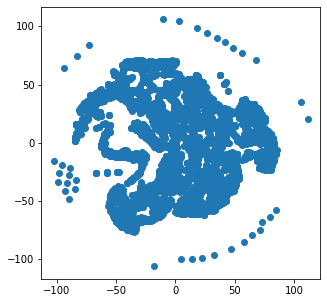

In [37]:
X_embedded = TSNE(n_components=2, random_state=345).fit_transform(X)
X_embedded.shape
pl.figure(figsize=(5,5))
pl.scatter(X_embedded[:,0], X_embedded[:,1])
pl.show()

Figure 3: Illustration of the t-SNE projection from 34 dimensions down to 2.  Optimally, we would like to see seperation into seperate clusters down in 2 dimensions, as it would indicate distancing in the higher dimensional paramter space.  In our plot we see clear signs of groups forming, from the snake in the midle left portion to the extension on the right side.

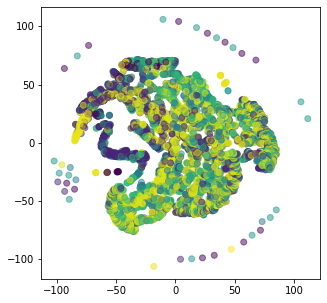

In [38]:
norm_obj= Normalize(vmin=y.min(), vmax=y.max())
len([c for c in pl.cm.RdBu_r(norm_obj(y.values))]), X_embedded.shape
pl.figure(figsize=(5,5))
pl.scatter(X_embedded[:,0], X_embedded[:,1],  
           color=[c for c in pl.cm.viridis(norm_obj(y.values))], alpha=0.5);

Figure 4: Similar to Figure 3, except colorcoded based on the target variable.  For this instance, the plot doesn't show much more from the colorcoding.

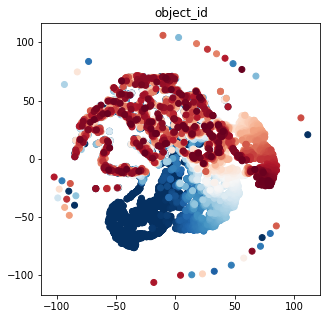

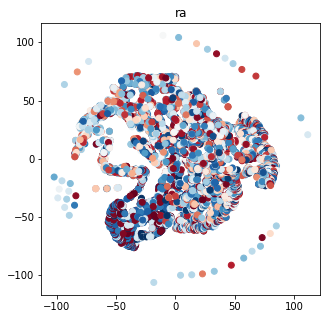

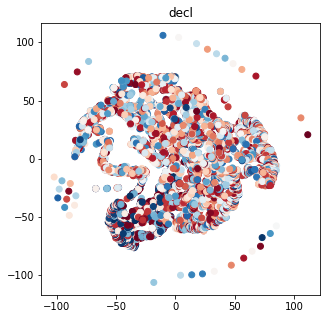

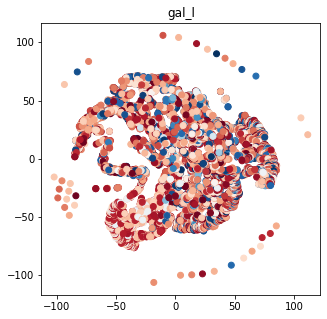

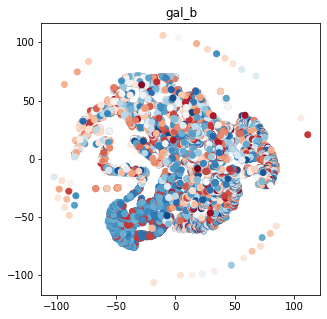

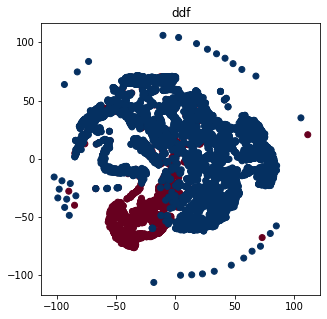

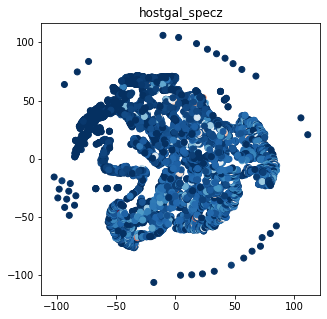

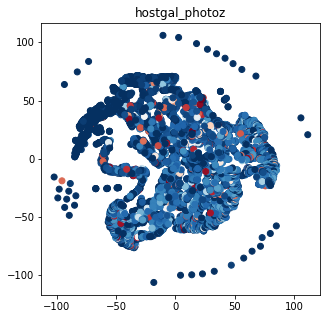

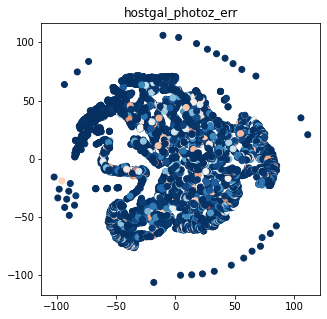

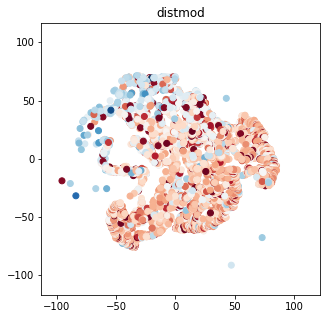

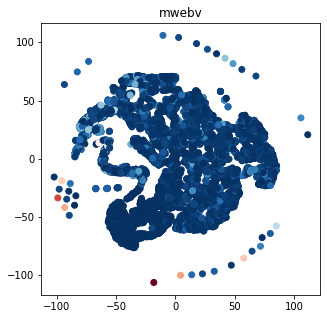

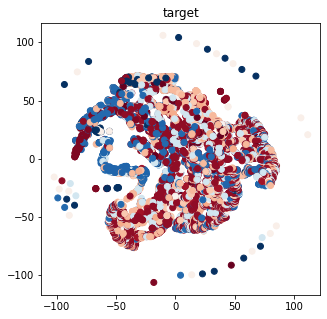

In [39]:
for col in metadata.columns:
    v = metadata[col].astype(float)
    pl.figure(figsize=(5,5))
    pl.title(col)
    pl.scatter(X_embedded[:,0], X_embedded[:,1],  color=[pl.cm.RdBu_r(Normalize(vmin=v.min(), vmax=v.max())(c))
                                                         for c in v])

    pl.show()

Figure 5: An extension of the colorcoding done in Figure 4 to all other variables in Metadata.  Note the object_id, ddf, and distmod plots show extensive seperation in the data, and in application purposes would be vitally important in our analysis: object_id shows seperation in the top and bottom half, ddf shows separation in an individual group in the bottom left, and distmod shows separation in individuals at the top of the plot.

I want to say informally that this method is really cool, and I'll be playing around with this more in the future.

# **-------------------------------------------------**

# **-------------------------------------------------**

# --- HW6 STARTS HERE ---

Note that I used 33 features in HW5, thus that's what we're continuing with.

In [0]:
allfeatures = allfeatures.replace([np.inf, -np.inf], np.nan).dropna(axis=1)
featuremeans = allfeatures.mean()[:-1].to_numpy()
featurestd = allfeatures.std()[:-1].to_numpy()

In [0]:
X = allfeatures.iloc[:,:-1].values
y = allfeatures.iloc[:,-1].values


In [205]:
print("saved means and standard deviation arrays", featuremeans, featurestd)
print("number of observcations {}, features {}, means {}, standard deviations {}".format(
    *X.shape, featuremeans.shape[0], featurestd.shape[0]))

saved means and standard deviation arrays [ 4.81e+07  9.32e+13  3.42e+20 -7.31e-02  3.24e-04  6.37e-03  3.17e+10
  4.76e+15 -1.58e-01 -4.47e-03  2.59e-02  1.68e+11  8.88e+16 -2.02e-01
 -2.49e-03  3.19e-02  2.77e+11  1.83e+17 -1.94e-01 -1.69e-03  2.11e-02
  5.63e+11  2.22e+17 -1.69e-01  6.94e-04 -3.42e-03  9.92e+11  5.34e+17
 -1.19e-01  3.35e-04 -4.26e-03 -2.73e+01  2.70e-01] [4.35e+07 8.26e+15 3.03e+22 2.08e-01 9.09e-02 4.89e-01 2.03e+12 3.61e+17
 2.45e-01 1.09e-01 5.69e-01 1.40e+13 7.82e+18 2.33e-01 5.29e-02 6.02e-01
 2.37e+13 1.61e+19 2.35e-01 5.46e-02 6.03e-01 4.80e+13 1.96e+19 2.13e-01
 3.78e-02 5.69e-01 8.50e+13 4.70e+19 1.89e-01 3.26e-02 5.11e-01 2.02e+01
 4.44e-01]
number of observcations 7848, features 33, means 33, standard deviations 33


In [0]:
from sklearn import preprocessing

In [223]:
X_scaled = preprocessing.scale(X)
print("scaled training data feature mean and standard deviations: ", 
      X_scaled.mean(axis=0), X_scaled.std(axis=0))

scaled training data feature mean and standard deviations:  [-5.79e-17 -2.72e-18 -3.62e-18  2.17e-17  1.09e-17  7.24e-18  3.62e-18
 -2.72e-18 -1.09e-17  4.53e-18 -1.04e-17 -4.53e-18  1.81e-18  3.62e-18
  1.18e-17 -3.17e-18  0.00e+00 -9.05e-19 -1.45e-17 -1.09e-17 -2.26e-18
  2.72e-18 -9.05e-19  2.17e-17  7.24e-18 -1.63e-17 -9.05e-19  1.81e-18
 -2.90e-17 -7.24e-18  6.34e-18 -2.17e-17 -5.79e-17] [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1.]


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


Sklearn warns of possible numerical issues, but for now we'll continue.

# Redoing TSNE

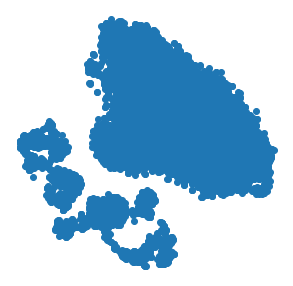

In [80]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, random_state=345).fit_transform(X_scaled)
X_embedded.shape
pl.figure(figsize=(5,5))
pl.scatter(X_embedded[:,0], X_embedded[:,1])
pl.axis('off')
pl.show()

Figure 1: The 2-D projection of our 33-dimensional feature space using t-distributed stochastic neighbor embedding (t-SNE).  There are two steps to the process: first, a probability distribution is constructed over the high-dimensional feature space in a way to group similar objects together.  Then, it constructs probability distribution in the low dimension map, finally minimizing the Kullback-Liebler divergence over the two distributions.  The KL divergence is a similarity measure of two distributions, thus by using gradient descent we can make the distributios similar with respect to the datapoints. The result is a shape with clusters such as shown above.  We can note two main clusters, with multiple sub-clusters in the lower half.

Text(0.5, 1.0, 'colored by target')

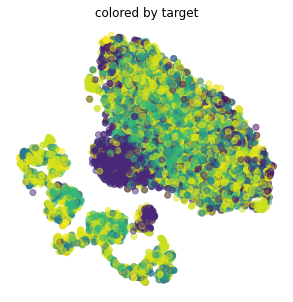

In [427]:
norm_obj= Normalize(vmin=y.min(), vmax=y.max())
len([c for c in pl.cm.RdBu_r(norm_obj(y))]), X_embedded.shape
pl.figure(figsize=(5,5))
pl.axis('off')
pl.scatter(X_embedded[:,0], X_embedded[:,1],  
           color=[c for c in pl.cm.viridis(norm_obj(y))], alpha=0.5);

pl.title("colored by target")

Figure 2: In using t-SNE, we look for high-purity when the points are colored against a variable, showing clusters.  In this case of coloring our projection against the target variable, we see little sign of purity.

Due to lack of purity, we'll plot against other variables:

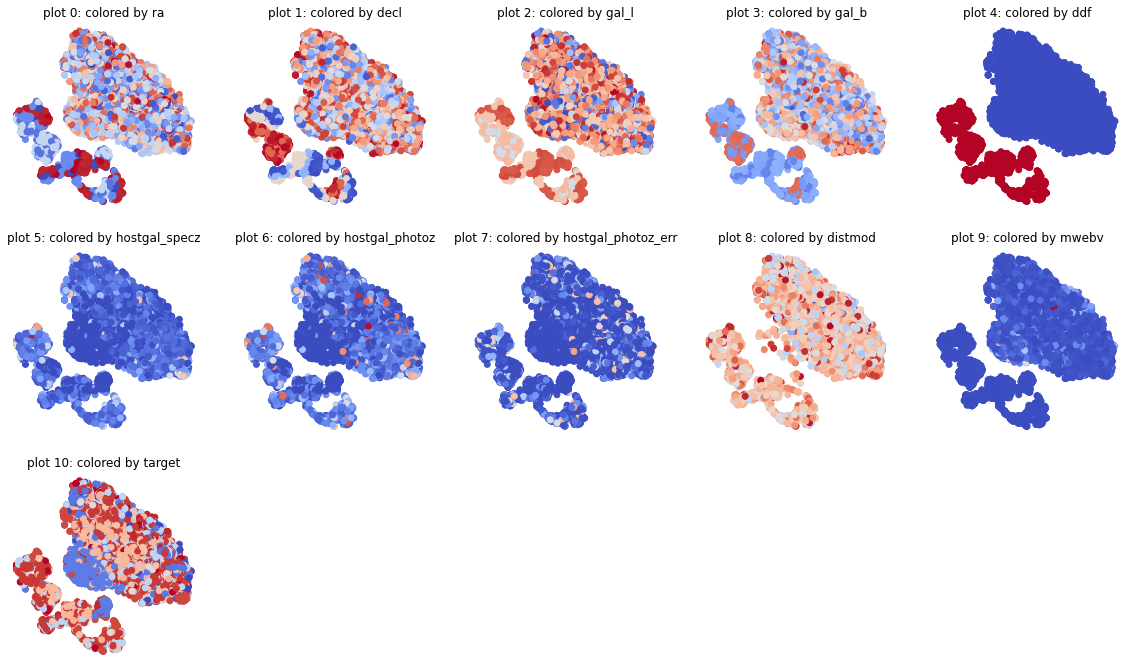

In [82]:
fig = pl.figure(figsize=(20,20))
# note: I am avoiding the first column of metadata which is the object identifier
for i, col in enumerate(metadata.columns[1:]):
    ax = fig.add_subplot(5,5,i+1)
    v = metadata[col].astype(float)
    ax.set_title("plot %d: colored by %s"%(i,col))
    ax.scatter(X_embedded[:,0], X_embedded[:,1],  
               color=[pl.cm.coolwarm(Normalize(vmin=v.min(), vmax=v.max())(c))
                                                         for c in v])
    ax.axis('off')

    #pl.show()



Figure 3: Plot of the t-SNE projection with all other available variables.  By far the greatest purity we see is in the ddf coloring in row 1, column 5.  This indicates to us that when doing any computation on the dataset, it would be advisable to split the data in terms of the differing values of ddf.  This is our motivation in classifying data with different ddf values in our random forest algorithms below.  Note that almost all other features show a poor mapping of the data.

In [425]:
allfeatures

,object_id,"(0, m3)","(0, m4)","(0, medians)","(0, slopes)","(0, intercepts)","(1, m3)","(1, m4)","(1, medians)","(1, slopes)","(1, intercepts)","(2, m3)","(2, m4)","(2, medians)","(2, slopes)","(2, intercepts)","(3, m3)","(3, m4)","(3, medians)","(3, slopes)","(3, intercepts)","(4, m3)","(4, m4)","(4, medians)","(4, slopes)","(4, intercepts)","(5, m3)","(5, m4)","(5, medians)","(5, slopes)","(5, intercepts)",decl,ddf,target
0,615,7.266579e+04,7.433032e+07,-0.080537,0.005676,-0.175947,8.593916e+07,2.215166e+11,-0.170090,0.014032,-0.399902,3.040627e+07,6.659406e+10,-0.289021,0.017676,-0.503760,1.049664e+07,1.919999e+10,-0.122434,0.020475,-0.583524,4.717542e+06,1.036570e+10,-0.163078,0.022343,-0.636786,3.041829e+06,1.049535e+10,-0.129163,0.021319,-0.596932,-61.943836,1,92
1,713,8.963424e+01,4.907398e+03,-0.052914,-0.041433,1.429423,-1.551087e+01,1.944373e+03,0.080189,-0.051648,1.420320,-4.127475e+00,1.935955e+03,0.117188,-0.053887,1.481892,-4.249286e+01,3.091660e+03,0.141552,-0.050983,1.402038,-1.597455e+01,2.938985e+03,0.016870,-0.050464,1.387765,7.377121e+01,5.294322e+03,-0.094281,-0.037903,1.042343,-27.784405,1,88
2,730,2.093148e+00,3.655013e+01,0.039463,-0.001798,0.063840,2.623669e+00,3.870188e+01,0.016754,0.003167,-0.080770,3.864890e+02,6.926529e+03,-0.343392,0.026905,-0.686084,1.380135e+03,4.048490e+04,-0.314425,0.024491,-0.624531,2.936931e+03,1.060595e+05,-0.308522,0.022552,-0.563811,3.751336e+03,1.860606e+05,-0.149763,0.019612,-0.490299,-6.579593,1,42
3,745,1.623684e+02,2.575248e+03,-0.169349,-0.013089,0.464675,1.161627e+05,2.162844e+07,-0.185994,-0.003826,0.105205,1.758302e+05,3.606109e+07,-0.290606,-0.003878,0.106641,1.519142e+05,2.575691e+07,-0.373246,-0.003931,0.108112,1.190633e+05,1.781661e+07,-0.358773,-0.004774,0.131296,5.309464e+04,6.203072e+06,-0.306851,-0.002816,0.076043,-45.586655,1,90
4,1124,-4.160853e+00,1.101222e+02,-0.033864,0.017117,-0.530614,1.202103e+03,3.545471e+04,-0.429236,0.028666,-0.816982,2.827915e+04,2.468546e+06,-0.438785,0.025384,-0.723449,6.198814e+04,7.271993e+06,-0.383411,0.021342,-0.608237,7.183273e+04,9.005039e+06,-0.303771,0.019736,-0.562470,3.414365e+04,3.279413e+06,-0.229697,0.015555,-0.435534,-63.823658,1,90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7843,130739978,6.069372e+03,3.961876e+05,-0.045003,0.010847,-0.086780,2.186608e+05,3.211401e+07,-0.282994,0.056925,-0.370012,2.263101e+03,8.382947e+04,-0.281585,0.009331,-0.107307,2.762651e+02,1.535764e+04,-0.245053,0.037509,-0.450103,1.838098e+03,2.604266e+05,-0.029408,-0.015218,0.235874,3.405476e+06,1.768533e+09,-0.091638,-0.021912,0.372506,-14.940303,0,65
7844,130755807,1.235441e+06,3.126406e+08,-0.264846,-0.062990,0.346445,9.514828e+03,4.645969e+05,-0.351126,-0.014109,0.070543,1.160262e+00,9.217903e+02,0.066620,0.049441,-0.420251,1.951863e+06,5.996601e+08,-0.258221,-0.004290,0.027885,2.798648e+06,8.667740e+08,-0.331122,0.009737,-0.116845,6.070907e+04,1.125906e+07,-0.108422,-0.003058,0.050458,-62.696659,0,90
7845,130762946,-1.685450e+05,2.694005e+07,0.164351,-0.057516,0.345093,-1.908115e+04,1.576221e+06,0.081505,0.109119,-0.872951,-1.794034e+03,1.570257e+06,-0.023363,-0.004481,0.051530,8.140885e+03,2.929589e+06,0.076775,-0.128830,1.030637,6.184648e+03,6.341943e+05,-0.107204,0.010708,-0.165973,1.565290e+05,3.826628e+07,-0.026542,0.003563,-0.053441,-55.682144,0,16
7846,130772921,3.363564e+03,1.343065e+05,-0.350661,0.019048,-0.123810,2.284544e+06,6.791051e+08,-0.302563,0.121633,-0.608166,6.365727e+02,1.796677e+04,-0.006650,0.022282,-0.267382,2.138969e+02,1.289186e+04,-0.180631,0.005771,-0.069255,-3.279862e+02,2.297857e+04,0.083647,-0.011086,0.155199,2.086790e+05,4.556694e+07,-0.107148,-0.019287,0.376104,-35.501846,0,65


# Performing the Clustering

In [0]:
from sklearn.cluster import AgglomerativeClustering

In [0]:
clustering = AgglomerativeClustering(n_clusters=3).fit(X_scaled)
#clustering = AgglomerativeClustering(n_clusters=3, affinity='chebychev', linkage='single').fit(X_scaled)

elements in cluster 0 5480
elements in cluster 1 1
elements in cluster 2 2367


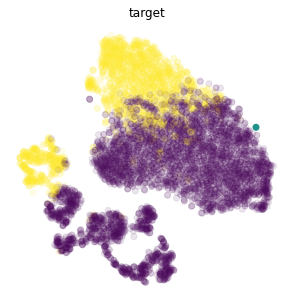

In [475]:
for j in range(3):
    print("elements in cluster {} {}".format(j, (clustering.labels_ == j).sum()))
pl.figure(figsize=(5,5))
pl.title(col)

#using a color map normalized according to the number of clusters:
# for 3 clusters vmin=0, vmax=2
colors = np.array([pl.cm.viridis(Normalize(vmin=0, vmax=2)(c))
                                                         for c in clustering.labels_])
# changing the alpha (transparency) based on the number of objects in the cluster or some clusters would not be visible
alpha = np.array([0.1 if (clustering.labels_ == j).sum() > 200 else 1.0 for j in clustering.labels_])
# setting the alpha channel by replacing the default of the colormap which is 1
colors[:,3] = alpha
    
pl.scatter(X_embedded[:,0], X_embedded[:,1], # alpha = alpha,
               color=colors);
pl.axis('off')
pl.show()


Figure 4: Agglomerative clustering using a Euclidian metric onto our t-SNE projection with 3 clusters.  Compared to Professor Bianco's clustering results, ours seems to be ineffective, a result that can be explained by not including all available features in the dataset.  Even by altering the parameters in the algorithm (affinity, linkage, n_clusters), a pure split between the two clusters was unobtainable.  

elements in cluster 0 7847
elements in cluster 1 1


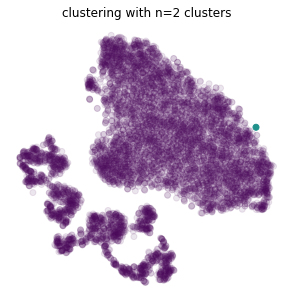

elements in cluster 0 5480
elements in cluster 1 1
elements in cluster 2 2367


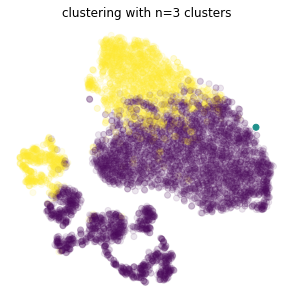

elements in cluster 0 3705
elements in cluster 1 1775
elements in cluster 2 2367
elements in cluster 3 1


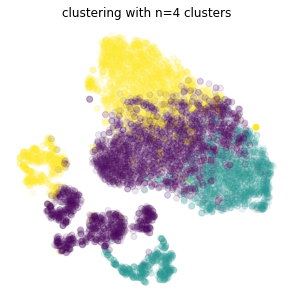

elements in cluster 0 3704
elements in cluster 1 1775
elements in cluster 2 2367
elements in cluster 3 1
elements in cluster 4 1


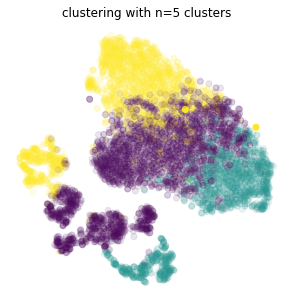

In [96]:
for n in range(2, 6):
  clustering = AgglomerativeClustering(n_clusters=n).fit(X_scaled)
  for j in range(n):
    print("elements in cluster {} {}".format(j, (clustering.labels_ == j).sum()))
  pl.figure(figsize=(5,5))
  pl.title(col)

  # for 3 clusters vmin=0, vmax=2
  colors = np.array([pl.cm.viridis(Normalize(vmin=0, vmax=2)(c))
                                                          for c in clustering.labels_])
  # changing the alpha (transparency) based on the number of objects in the cluster or some clusters would not be visible
  alpha = np.array([0.1 if (clustering.labels_ == j).sum() > 200 else 1.0 for j in clustering.labels_])
  # setting the alpha channel by replacing the default of the colormap which is 1
  colors[:,3] = alpha
      
  pl.scatter(X_embedded[:,0], X_embedded[:,1], # alpha = alpha,
                color=colors);
  pl.title("clustering with n=%s clusters" % n)
  pl.axis('off')
  pl.show()

Figure 5: Agglomerative clustering using a Euclidian metric with varying n_clusters parameter.  Note that the outliers in the dataset affect the clustering results severely--in the end, 2 our of the 5 clusters have single points in them.

# Extra Credit - Analyze outlier

Not completed in this notebook.

# Changing the Distance Metric

In [0]:
from scipy.spatial.distance import cdist

Braycurtis is a dissimilarity, it is not a metric since it doesn't satisfy the triangle inequality.  It is bounded between 0 and 1.

In [498]:
dist = cdist(X_scaled, X_scaled, metric='braycurtis')

clustering = AgglomerativeClustering(n_clusters=3, affinity='precomputed', 
                                    linkage="complete").fit(dist)
for j in range(2, -1, -1):
        print("elements in cluster {} {}".format(j, (clustering.labels_ == j).sum()))

elements in cluster 2 935
elements in cluster 1 3122
elements in cluster 0 3791


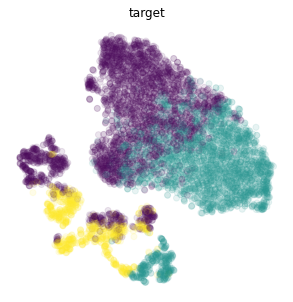

In [499]:
pl.figure(figsize=(5,5))
pl.title(col)

#using a color map normalized according to the number of clusters:
# for 3 clusters vmin=0, vmax=2
colors = np.array([pl.cm.viridis(Normalize(vmin=0, vmax=2)(c))
                                                         for c in clustering.labels_])
# changing the alpha (transparency) based on the number of objects in the cluster or some clusters would not be visible
alpha = np.array([0.1 if (clustering.labels_ == j).sum() > 200 else 1.0 for j in clustering.labels_])
# setting the alpha channel by replacing the default of the colormap which is 1
colors[:,3] = alpha
    
pl.scatter(X_embedded[:,0], X_embedded[:,1], # alpha = alpha,
               color=colors);
pl.axis('off')
pl.show()

Figure 6: The result of clustering using the Bray-Curtis dissimilarity.  Note the biggest change in the clustering is in the big mass of datapoints at the top, as datapoints are more scattered in the middle of the mass.  We repeat as we did before that the clustering is not optimal in these situations, and this similarity metric is likely not the most suitable for this situation

# Extra Credit 2: Mahalobis

In [0]:
dist = cdist(X, X, metric='mahalanobis')

In [493]:
clustering = AgglomerativeClustering(n_clusters=30, affinity='precomputed', 
                                    linkage="complete").fit(dist)
for j in range(2, -1, -1):
        print("elements in cluster {} {}".format(j, (clustering.labels_ == j).sum()))

elements in cluster 2 3
elements in cluster 1 3
elements in cluster 0 7668


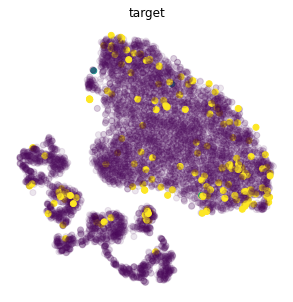

In [494]:
pl.figure(figsize=(5,5))
pl.title(col)

#using a color map normalized according to the number of clusters:
# for 3 clusters vmin=0, vmax=2
colors = np.array([pl.cm.viridis(Normalize(vmin=0, vmax=2)(c))
                                                         for c in clustering.labels_])
# changing the alpha (transparency) based on the number of objects in the cluster or some clusters would not be visible
alpha = np.array([0.1 if (clustering.labels_ == j).sum() > 200 else 1.0 for j in clustering.labels_])
# setting the alpha channel by replacing the default of the colormap which is 1
colors[:,3] = alpha
    
pl.scatter(X_embedded[:,0], X_embedded[:,1], # alpha = alpha,
               color=colors);
pl.axis('off')
pl.show()

Figure 7: Clustering using the Mahalobis metric using 30 clusters.  30 clusters were used to illustrate the tendancy of the Mahalobis metric to isolate individual points instead of actually cluster, indicative that the Mahalobis was either implemented incorrectly or is not suitable for this dataset.  It is clearly less efficient than the Euclidian metric, in this situation.

# Extra Credit 3: DBScan

Elements in DBScan can either be a core point (specified by a certain number of points being within a certain distance from it, which is defined in min_samples), a border point (a point within the radius of a core point, but with too few samples in its radius to be a core point), or an outlier (a point that's not a core or a border). 

I messed around with DBScan for a while.  The best luck I had was when I changed the metrics from Euclidian to Chebyschev (the infinity norm).

In [500]:
DBclustering = sklearn.cluster.DBSCAN(eps=2, min_samples=20, metric='chebyshev', 
                          metric_params=None, algorithm='auto', leaf_size=30).fit(X_scaled)


for j in range(len(np.unique(DBclustering.labels_)), -1, -1):
        print("elements in cluster {} {}".format(j, (DBclustering.labels_ == j).sum()))

elements in cluster 3 0
elements in cluster 2 0
elements in cluster 1 5673
elements in cluster 0 2115


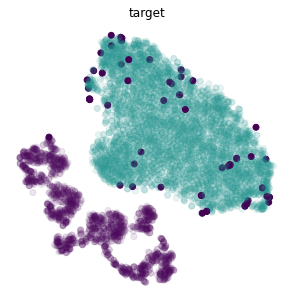

In [501]:
pl.figure(figsize=(5,5))
pl.title(col)

#using a color map normalized according to the number of clusters:
# for 3 clusters vmin=0, vmax=2

colors = np.array([pl.cm.viridis(Normalize(vmin=0, vmax=2)(c))
                                                         for c in DBclustering.labels_])
# changing the alpha (transparency) based on the number of objects in the cluster or some clusters would not be visible
alpha = np.array([0.1 if (DBclustering.labels_ == j).sum() > 200 else 1.0 for j in DBclustering.labels_])
# setting the alpha channel by replacing the default of the colormap which is 1
colors[:,3] = alpha
    
pl.scatter(X_embedded[:,0], X_embedded[:,1], # alpha = alpha,
               color=colors);
pl.axis('off')
pl.show()

Figure 8: Clustering with DBScan, using the infinity norm.  For this cluster, eps=2 and min_samples=20.  min_samples too low and the entire plot became one cluster, same with eps too high.  More tinkering will need to be done to get better separation.  One such possibility is using the minkowski metric instead of Euclidian.

Note: I attempted to use Minkowski but got errors, likely from the minkowski metric not being updated to be compatible with python 3.

# Classification with Regular Random Forests

We'll do this step by step: First, we train-test split using 20% of the data for the test set.  Then, we fit our random forest on the training data.  Finally, we evalute the performance of our random forest on the test set.

Random forests work by creating independent trees in series by sampling the observations (or features), then taking a majority vote on all the trees to see how to classify the new observation.

In [0]:
allfeat0 = allfeatures.loc[allfeatures["ddf"]==0]
allfeat1 = allfeatures.loc[allfeatures["ddf"]==1]

# features and target for ddf=0
X1 = allfeat0.iloc[:,:-1].values
y1 = allfeat0.iloc[:,-1].values

# features and target for ddf=1
X2 = allfeat1.iloc[:,:-1].values
y2 = allfeat1.iloc[:,-1].values

# our final datasets:
X_trdf, X_tedf, y_trdf, y_tedf = train_test_split(X1, y1, test_size=0.2)
X_trnorm, X_tenorm, y_trnorm, y_tenorm = train_test_split(X2, y2, test_size=0.2)

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

First, we'll initialize our forest:

In [0]:
rfdf = RandomForestClassifier(max_depth=5)

Then, we fit the random forest:

In [580]:
rfdf.fit(X_trdf, y_trdf)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Now we'll produce our score:

In [581]:
rfdf.score(X_tedf, y_tedf)

0.4594594594594595

This score is the test accuracy of our random forest. Doing this by hand, we get:

In [582]:
sum((rfdf.predict(X_tedf) == y_tedf).astype(int))/len(y_tedf)

0.4594594594594595

which is the exact result: the number of test instances classified correctly divided by the total number of instances.

Now let's do this same thing for the normal survey:

In [0]:
rfnorm = RandomForestClassifier(max_depth=5)

In [584]:
rfnorm.fit(X_trnorm, y_trnorm)
rfnorm.score(X_tenorm, y_tenorm)

0.6816037735849056

In [585]:
sum((rfnorm.predict(X_tenorm) == y_tenorm).astype(int))/len(y_tenorm)

0.6816037735849056

In [586]:
print("Random Forest Classification\n" + 
       "score on DDF {:.2f} and on normal survey {:.2f}".format(
           rfdf.score(X_tedf, y_tedf),
           rfnorm.score(X_tenorm, y_tenorm)))

Random Forest Classification
score on DDF 0.46 and on normal survey 0.68


For now, these results seem acceptable.

# Gradient Boosted Random Forest

This gradient boosted forest differs from the regular random forest in that it doesn't create a parallel of independent trees--the trees are created in a sequence, and the features/observations are weighted for each tree of the sequence depending on the classification of the last tree.  The term "Gradient Boosted" refers to the fact that gradient descent is set up on an optimization problem to determine how to adjust the features and observations for the next step.  

In [0]:
from sklearn.ensemble import GradientBoostingClassifier

In [0]:
gbdf = GradientBoostingClassifier(max_depth=5)

Note now that we now have the parameter "learning rate" in our gradient boosting classifier, which is indicative of the fact that we're reweighting our features and observations in each step.  In our application, we won't mess with it.

First, for ddf:

In [589]:
gbdf.fit(X_trdf, y_trdf)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=5,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [590]:
gbdf.score(X_tedf, y_tedf)

0.5806451612903226

And now for normal:

In [0]:
gbnorm = GradientBoostingClassifier()

In [592]:
gbnorm.fit(X_trnorm, y_trnorm)
gbnorm.score(X_tenorm, y_tenorm)

0.7476415094339622

In [593]:
print("Gradient Boosted Random Forest Classification\n" + 
       "score on DDF {:.2f} and on normal survey {:.2f}".format(
           gbdf.score(X_tedf, y_tedf),
           gbnorm.score(X_tenorm, y_tenorm)))

Gradient Boosted Random Forest Classification
score on DDF 0.58 and on normal survey 0.75


The predictions were technically better for both for the gradient boosted random forest, however we must note that due to the random nature of both algorithms, this is hard to verify without repeating this experiment multiple times.  Due to the computation time of the gradient boosted random forest, this is difficult to do right now.

Also note: My scores are clearly not as good as Professor Bianco's, as I don't include all of the features that were available for classification.

# Confusion Matrix

The confusion matrix illustrates how well the classifier classified instances with respect to all other classes.  In each (i, j) entry of the matrix, the normalized confusion matrix tells us what percent of the true label i was predicted as j.  Thus, on the normalized confusion matrix, the rows should each sum to 1.  A desirable confusion matrix is one where the diagonals are filled, and all off-diagonal entries are 0, indicating perfect classification.  Any off-diagonal classification is indicative of a false positive for that corresponding class.

Confusion matrix, without normalization
Normalized confusion matrix
Confusion matrix, without normalization
Normalized confusion matrix


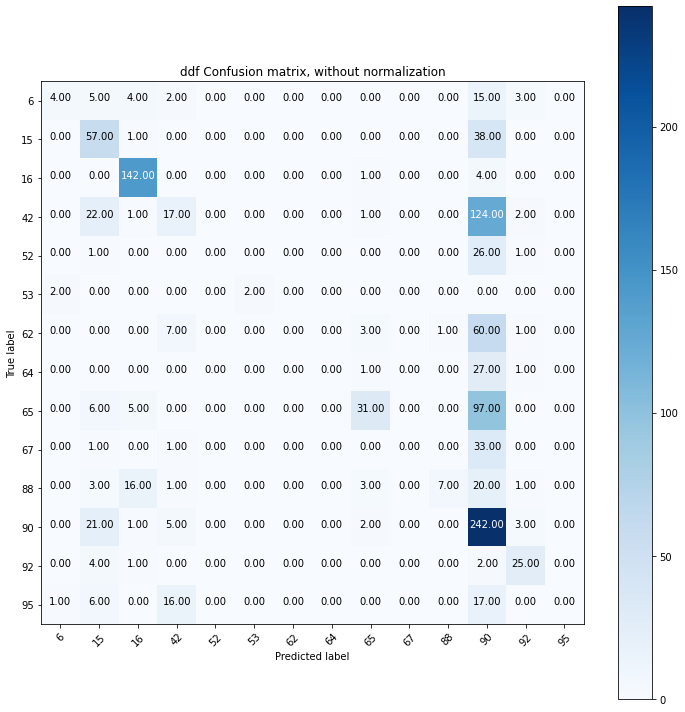

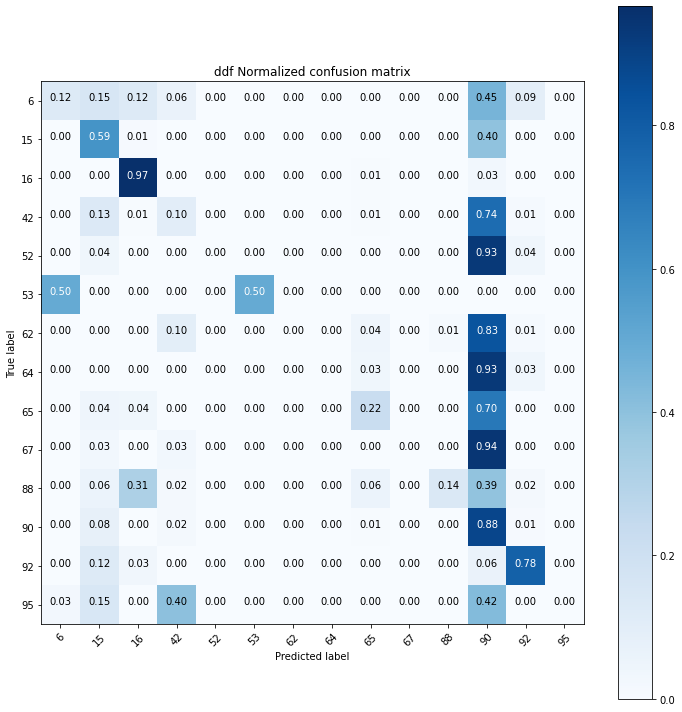

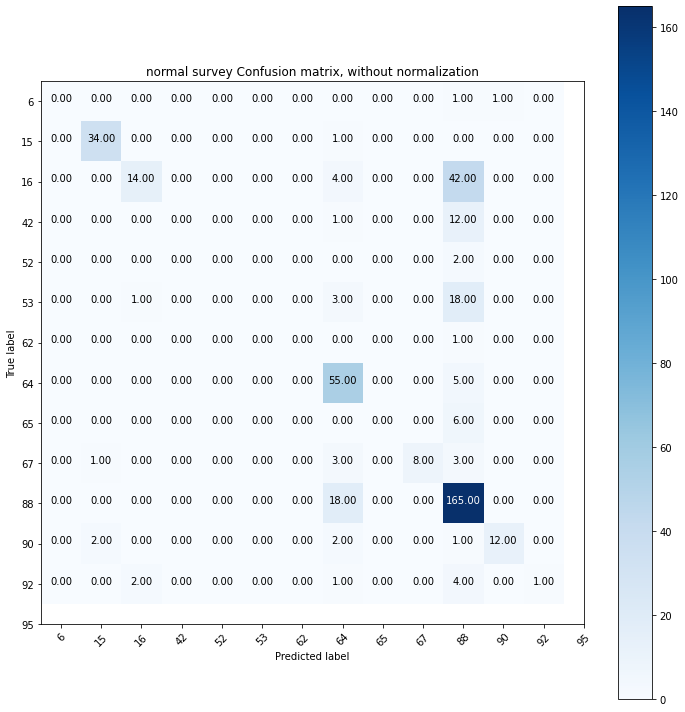

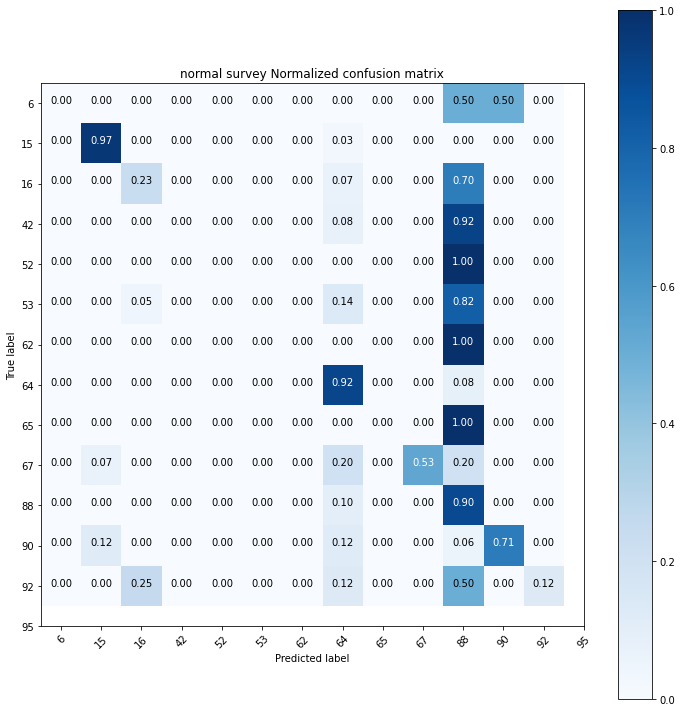

In [594]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "%.2f"%cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
# Compute confusion matrix for df
cnf_matrix = sklearn.metrics.confusion_matrix(y_tedf, rfdf.predict(X_tedf))

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10,10))
np.set_printoptions(precision=2)
plot_confusion_matrix(cnf_matrix, classes=["%d"%i for i in np.unique(y)],
                      title='ddf Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(10,10))
np.set_printoptions(precision=2)
plot_confusion_matrix(cnf_matrix, classes=["%d"%i for i in np.unique(y)], normalize=True,
                      title='ddf Normalized confusion matrix')

# Compute confusion matrix for norm
cnf_matrix = sklearn.metrics.confusion_matrix(y_tenorm, rfnorm.predict(X_tenorm))

np.set_printoptions(precision=2)


cnf_matrix = sklearn.metrics.confusion_matrix(y_tenorm, rfnorm.predict(X_tenorm))

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10,10))

plot_confusion_matrix(cnf_matrix, classes=["%d"%i for i in np.unique(y)],
                      title='normal survey Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(10,10))
np.set_printoptions(precision=2)
plot_confusion_matrix(cnf_matrix, classes=["%d"%i for i in np.unique(y)], normalize=True,
                      title='normal survey Normalized confusion matrix')


plt.show()

Figure 9: Confusion matrix for the regular random forest model on both the ddf and normal surveys.  It is worth pointing out that the regular random forest tended to overpredict label 90 on both the ddf and normal surveys, a potential sign of overfitting.  However, we do note that a sizable portion of the observations from both surveys is on the diagonal, which gives hope that the classifier can be reworked for better outputs.

# Gradient Boosted Confusion Matricies

Now we'll compute the confusion matricies for the gradient boosted models.

Confusion matrix, without normalization
Normalized confusion matrix
Confusion matrix, without normalization


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


Normalized confusion matrix


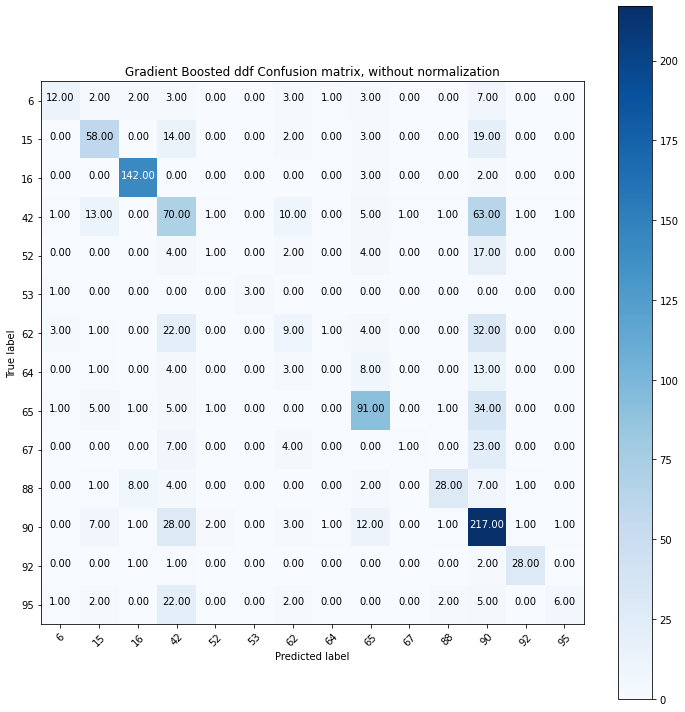

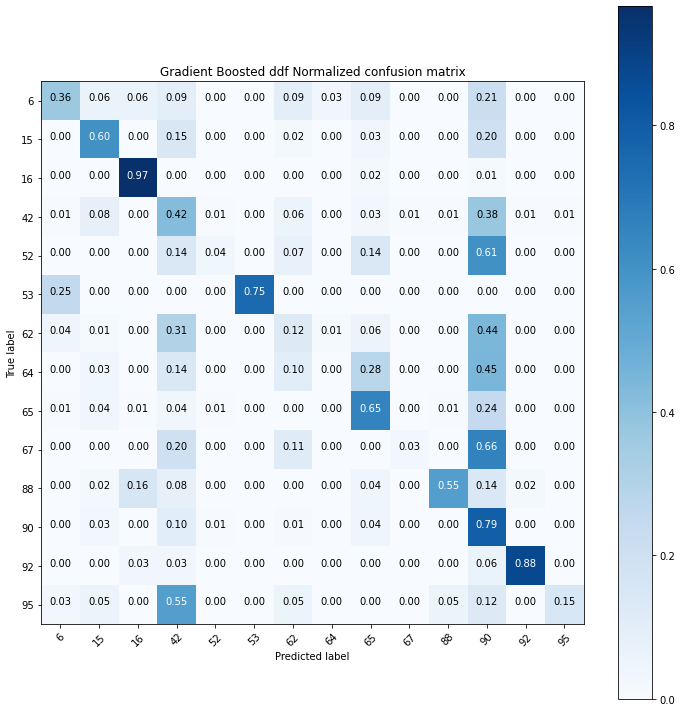

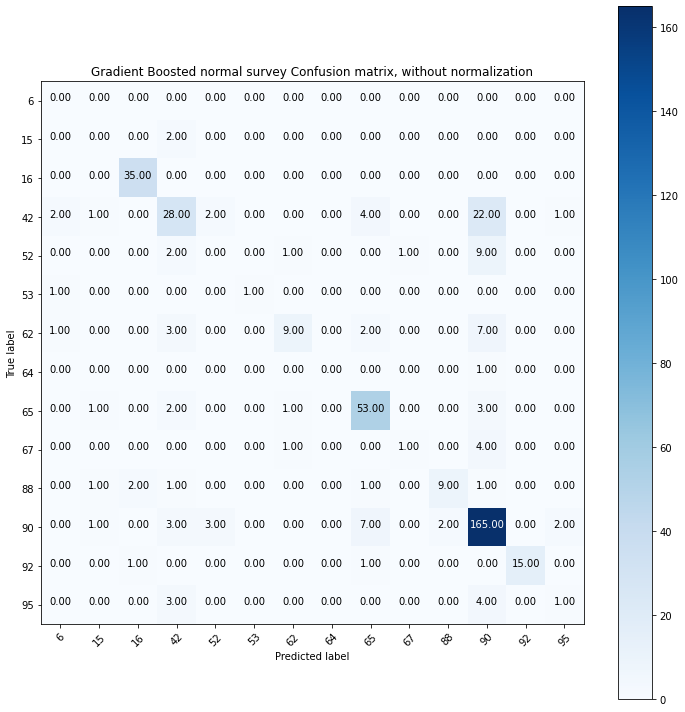

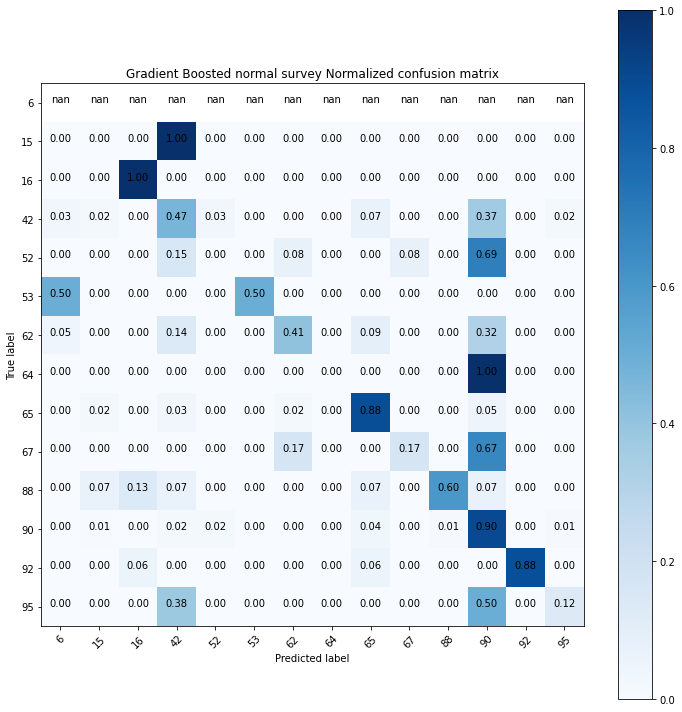

In [595]:
# Compute confusion matrix
cnf_matrix = sklearn.metrics.confusion_matrix(y_tedf, gbdf.predict(X_tedf))

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10,10))

plot_confusion_matrix(cnf_matrix, classes=["%d"%i for i in np.unique(y)],
                      title='Gradient Boosted ddf Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(10,10))
np.set_printoptions(precision=2)
plot_confusion_matrix(cnf_matrix, classes=["%d"%i for i in np.unique(y)], normalize=True,
                      title='Gradient Boosted ddf Normalized confusion matrix')

cnf_matrix = sklearn.metrics.confusion_matrix(y_tenorm, gbnorm.predict(X_tenorm))

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10,10))

plot_confusion_matrix(cnf_matrix, classes=["%d"%i for i in np.unique(y)],
                      title='Gradient Boosted normal survey Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(10,10))
np.set_printoptions(precision=2)
plot_confusion_matrix(cnf_matrix, classes=["%d"%i for i in np.unique(y)], normalize=True,
                      title='Gradient Boosted normal survey Normalized confusion matrix')

plt.show()


Figure 10: Confusion matricies for the gradient-boosted random forest model on the ddf survey and the normal survey.  Similar to the regular random forests, these models tended to overpredict label 90, a sign of overfitting.